In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import lyricsgenius
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from collections import Counter
import json


with open('spotify_genius_codes.json', 'r') as config_file:
    config = json.load(config_file)


genius_access_token = config['GENIUS_ACCESS_TOKEN']
spotify_client_id = config['SPOTIFY_CLIENT_ID']
spotify_client_secret = config['SPOTIFY_CLIENT_SECRET']

# Initialize APIs
genius = lyricsgenius.Genius(genius_access_token)
sp = spotipy.Spotify(auth_manager=SpotifyClientCredentials(client_id=spotify_client_id,
                                                           client_secret=spotify_client_secret))



In [ ]:
import time

# Define a function to fetch songs from Spotify
def fetch_songs_from_spotify(sp, year):
    # Search for playlists that are likely to contain top songs of the year
    playlists = sp.search(q=f'top hits {year}', type='playlist', limit=10)

    # Extract playlist IDs
    playlist_ids = [playlist['id'] for playlist in playlists['playlists']['items']]

    # Fetch songs from these playlists
    songs = []
    for playlist_id in playlist_ids:
        tracks = sp.playlist_tracks(playlist_id)
        for track_item in tracks['items']:
            # Check if track details are available
            if track_item and 'track' in track_item and track_item['track']:
                song = track_item['track']
                # Ensure all required fields are present
                if 'id' in song and 'name' in song and 'artists' in song and song['artists']:
                    songs.append({
                        'Spotify_ID': song['id'],
                        'Title': song['name'],
                        'Artist': song['artists'][0]['name'],
                        'Year': year,
                        'Genre': None
                    })
    return pd.DataFrame(songs)

# Define a function to fetch lyrics using Genius API
def fetch_lyrics(artist, title):
    try:
        song = genius.search_song(title, artist)
        return song.lyrics if song else "Lyrics Not Found"
    except Exception as e:
        print(f"Error fetching lyrics for {artist} - {title}: {e}")
        return "Lyrics Not Found"

# Collect data and fetch lyrics
all_songs_data = pd.DataFrame()
for year in range(2010, 2023):  # Adjust the range as needed
    print(f"Fetching songs for {year}...")
    yearly_songs = fetch_songs_from_spotify(sp, year)
    all_songs_data = pd.concat([all_songs_data, yearly_songs], ignore_index=True)

    # Pausing to respect rate limits (adjust the time as needed)
    time.sleep(1)

# Function to safely fetch lyrics
def safe_fetch_lyrics(row):
    return fetch_lyrics(row['Artist'], row['Title'])

print("Fetching lyrics...")
all_songs_data['lyrics'] = all_songs_data.apply(safe_fetch_lyrics, axis=1)


In [ ]:
# all_songs_data.to_csv('all_songs_data_csv.csv', index=False)
# all_songs_data.to_json('all_songs_data_json.json', orient='records', lines=True)


In [2]:

all_songs_data = pd.read_csv('all_songs_data_csv.csv')
#all_songs_data = pd.read_json('all_songs_data_json.json', orient='records', lines=True)


In [4]:
# Tokenize lyrics and remove stop words
stop_words = set(stopwords.words('english'))

def process_lyrics(lyrics):
    word_tokens = word_tokenize(lyrics)
    filtered_lyrics = [w.lower() for w in word_tokens if not w.lower() in stop_words and w.isalpha()]
    return filtered_lyrics

all_songs_data['processed_lyrics'] = all_songs_data['lyrics'].apply(process_lyrics)

# Calculate word frequency
word_freq = Counter()
for lyrics in all_songs_data['processed_lyrics']:
    word_freq.update(lyrics)

# Display most common words
print(word_freq.most_common(100))


[('like', 51617), ('feat', 46557), ('love', 34627), ('yeah', 34034), ('know', 33510), ('oh', 29400), ('got', 26343), ('one', 25615), ('go', 23911), ('na', 23714), ('chorus', 23033), ('get', 22751), ('baby', 21455), ('let', 21078), ('de', 18985), ('la', 18344), ('verse', 17896), ('never', 17812), ('see', 17596), ('time', 17121), ('want', 15866), ('say', 15733), ('might', 15282), ('make', 15091), ('back', 14677), ('come', 14631), ('wan', 14087), ('ca', 13725), ('would', 13604), ('way', 13129), ('take', 12768), ('good', 12494), ('could', 12443), ('man', 11671), ('right', 11626), ('night', 11593), ('also', 11342), ('gon', 11252), ('life', 11131), ('said', 11093), ('feel', 11092), ('us', 10934), ('hey', 10931), ('lil', 10851), ('tell', 10755), ('need', 10626), ('que', 10124), ('day', 10037), ('ai', 9882), ('lyrics', 9790), ('girl', 9574), ('little', 9309), ('think', 9200), ('ooh', 8975), ('give', 8900), ('heart', 8273), ('look', 8123), ('away', 7888), ('world', 7842), ('still', 7740), ('min

In [6]:
all_songs_data['Spotify_ID'] = all_songs_data.apply(lambda row: f"{row['Artist']}_{row['Title']}" if pd.isna(row['Spotify_ID']) else row['Spotify_ID'], axis=1)



# Create a network graph
G = nx.Graph()

# Add nodes
for index, row in all_songs_data.iterrows():
    G.add_node(row['Spotify_ID'], title=row['Title'], artist=row['Artist'], year=row['Year'])

# Define a function to determine if two songs should be connected
def should_connect(song1, song2):
    # Example logic: connect songs if they share the same artist
    return song1['artist'] == song2['artist']

# Add edges
for song1_id, song1_data in G.nodes(data=True):
    for song2_id, song2_data in G.nodes(data=True):
        if song1_id != song2_id and should_connect(song1_data, song2_data):
            G.add_edge(song1_id, song2_id)

# Analyze the network (e.g., find important nodes)
degree_centrality = nx.degree_centrality(G)
# Sort nodes by degree centrality
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)
print("Top 10 nodes by degree centrality:", sorted_degree[:10])


Top 10 nodes by degree centrality: [('4KD2JurNTeKSpZxnLrZPav', 0.01843640606767795), ('7ipmdGgjEpfVBEV2EyqPZk', 0.01843640606767795), ('2ktfgle7ZJwiroVq95fJKN', 0.01843640606767795), ('7t8aqkbfWFoMxEWxxCQTcN', 0.01843640606767795), ('68W4jM5guSYyKWGlQoOFP9', 0.01843640606767795), ('1wpKqiPKw9dwgspB88v1fD', 0.01843640606767795), ('2LlvWJ67p4Xts2RzOjs1RS', 0.01843640606767795), ('2vNLVWDDVzYUlkO0Q816Vu', 0.01843640606767795), ('1rMZjIc3MkRzgzi2QbKyRN', 0.01843640606767795), ('5aCBjDsNLQyJ26mash87z7', 0.01843640606767795)]


In [6]:
# Analyze the network (e.g., find important nodes)
degree_centrality = nx.degree_centrality(G)

# Sort nodes by degree centrality
sorted_degree = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)

# Print the top 10 nodes by degree centrality along with the corresponding artist
print("Top 10 nodes by degree centrality:")
for node_id, centrality in sorted_degree[:10]:
    artist = G.nodes[node_id]['artist']
    title = G.nodes[node_id]['title']
    print(f"Artist: {artist}, Song: {title}, Centrality: {centrality}")


Top 10 nodes by degree centrality:
Artist: Klevi, Song: Carnal, Centrality: 0.01843640606767795
Artist: Klevi, Song: Tu me reconnais, Centrality: 0.01843640606767795
Artist: Klevi, Song: Si Mal, Centrality: 0.01843640606767795
Artist: Klevi, Song: Que ca fume, Centrality: 0.01843640606767795
Artist: Klevi, Song: J'essaie d'oublier, Centrality: 0.01843640606767795
Artist: Klevi, Song: J'arrive pas, Centrality: 0.01843640606767795
Artist: Klevi, Song: J'ai fait le tour, Centrality: 0.01843640606767795
Artist: Klevi, Song: Intro, Centrality: 0.01843640606767795
Artist: Klevi, Song: Ils sont pas prêts, Centrality: 0.01843640606767795
Artist: Klevi, Song: Hola, Centrality: 0.01843640606767795


In [7]:
songs_with_centrality = pd.DataFrame({
    'Spotify_ID': list(degree_centrality.keys()),
    'Centrality': list(degree_centrality.values())
}).merge(all_songs_data[['Spotify_ID', 'Artist', 'Title']], on='Spotify_ID')

# Group by artist and get the song with the highest centrality for each artist
top_song_per_artist = songs_with_centrality.loc[songs_with_centrality.groupby('Artist')['Centrality'].idxmax()]

# Sort the artists by their top song's centrality
sorted_artists = top_song_per_artist.sort_values(by='Centrality', ascending=False)

# Limit to top 10 artists
top_N_artists = sorted_artists.head(50)

# Display the top 10 artists with their top song
for index, row in top_N_artists.iterrows():
    print(f"Artist: {row['Artist']}, Top Song: {row['Title']}, Centrality: {row['Centrality']}")

Artist: Klevi, Top Song: Carnal, Centrality: 0.01843640606767795
Artist: Drake, Top Song: Over, Centrality: 0.014235705950991833
Artist: Taylor Swift, Top Song: Back To December, Centrality: 0.014002333722287048
Artist: The Weeknd, Top Song: The Hills, Centrality: 0.00956826137689615
Artist: Maroon 5, Top Song: Misery, Centrality: 0.009101516919486581
Artist: Katy Perry, Top Song: California Gurls, Centrality: 0.008868144690781798
Artist: Rihanna, Top Song: Only Girl (In The World), Centrality: 0.00840140023337223
Artist: Ariana Grande, Top Song: The Way, Centrality: 0.00840140023337223
Artist: BTS, Top Song: Yet To Come, Centrality: 0.008168028004667444
Artist: David Guetta, Top Song: Memories (feat. Kid Cudi), Centrality: 0.007467911318553093
Artist: Ed Sheeran, Top Song: Shape of You, Centrality: 0.007001166861143524
Artist: Lady Gaga, Top Song: Bad Romance, Centrality: 0.00676779463243874
Artist: Adele, Top Song: Rolling in the Deep, Centrality: 0.006067677946324387
Artist: Calvin 

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import pandas as pd

# Assuming 'lyrics' and 'Year' columns are in all_songs_data
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(all_songs_data['lyrics'])

# Calculate cosine similarity
cosine_sim = cosine_similarity(tfidf_matrix)

# Optimize the calculation of average year similarity
n_songs = len(all_songs_data)
year_similarity = pd.DataFrame(cosine_sim, index=all_songs_data['Year'], columns=all_songs_data['Year'])

# Replace similarity with the same year with NaN
for year in year_similarity.columns:
    year_similarity.loc[year, year] = np.nan

# Calculate the average similarity for each year pair
average_year_similarity = year_similarity.stack().groupby(level=[0, 1]).mean()

# Identify most similar year pairs
most_similar_years = average_year_similarity.sort_values(ascending=False)

# Display the most similar year pairs
print("Most similar year pairs based on lyrics:")
for (year1, year2), similarity in most_similar_years.head(10).items():
    print(f"Years: {year1}, {year2}, Similarity: {similarity:.4f}")


MemoryError: Unable to allocate 954. MiB for an array with shape (125007286,) and data type int64

# Network Graph

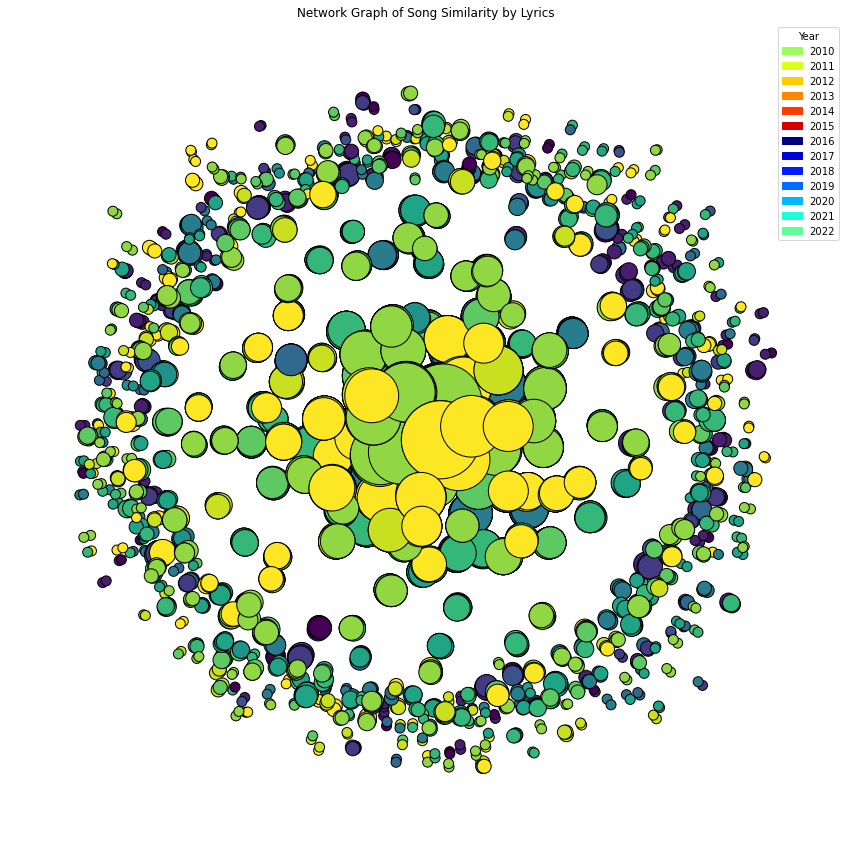

In [20]:
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.preprocessing import minmax_scale
import matplotlib.patches as mpatches


# Calculate degree centrality
degree_centrality = nx.degree_centrality(G)

# Scale the centrality values to a range that's suitable for node sizes
# Here we're scaling the degree centrality values to be between 10 and 100
scaled_degree_centrality = minmax_scale(list(degree_centrality.values()), feature_range=(10, 100))

# Create a mapping of node labels to their scaled centrality values
node_sizes = {node: size for node, size in zip(G.nodes(), scaled_degree_centrality)}


unique_years = sorted(all_songs_data['Year'].unique())
color_map = plt.cm.get_cmap('viridis', len(unique_years))
year_color_map = {year: color_map(i) for i, year in enumerate(unique_years)}

# Scale the centrality values to a range that's suitable for node sizes
# Adjust the feature_range as needed to make the nodes larger or smaller
scaled_degree_centrality = minmax_scale(list(degree_centrality.values()), feature_range=(900, 1000))
node_sizes = {node: size for node, size in zip(G.nodes(), scaled_degree_centrality)}


# Draw the network graph using the centrality to determine node size

plt.figure(figsize=(15, 15), facecolor='white')
pos = nx.spring_layout(G, weight='weight')  # Position nodes based on the 'weight' of the edges
# Draw the graph
# fig, ax = plt.subplots(figsize=(15, 15))
# ax.set_facecolor('skyblue')

nx.draw_networkx_edges(G, pos, alpha=0.1)  # Draw edges with low alpha to reduce visual clutter
nx.draw_networkx_nodes(G, pos, node_size = [G.degree(n)*100 for n in G.nodes()],
                       node_color=[year_color_map[data['year']] for _, data in G.nodes(data=True)],
                       cmap=plt.cm.jet, edgecolors='black')  # Use a colormap for node colors
#nx.draw_networkx_labels(G, pos, font_size=5, alpha=0.7)  # Optionally add labels
year_color_map = {year: plt.cm.jet(i/len(set(all_songs_data['Year']))) for i, year in enumerate(set(all_songs_data['Year']))}

# Assign colors to nodes based on year
#node_color = [year_color_map[data['year']] for _, data in G.nodes(data=True)]

# Set node size based on degree (number of connections)
#node_size = [G.degree(n)*100 for n in G.nodes()]


legend_handles = [mpatches.Patch(color=year_color_map[year], label=str(year)) for year in unique_years]
plt.legend(handles=legend_handles, title="Year", loc='best')
# Create a color bar for the year legend if needed (as shown in previous examples)

plt.title('Network Graph of Song Similarity by Lyrics')
plt.axis('off')
plt.show()

In [22]:
import community as community_louvain

# Calculate various centrality metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)

# Get the community (modularity class) for each node
communities = community_louvain.best_partition(G)

# Create a DataFrame to hold the metrics
metrics_df = pd.DataFrame({
    'Spotify_ID': G.nodes(),
    'Degree Centrality': degree_centrality.values(),
    'Betweenness Centrality': betweenness_centrality.values(),
    'Closeness Centrality': closeness_centrality.values(),
    'Community': [communities[node] for node in G.nodes()]
})



In [26]:
# Merge the metrics DataFrame with the original song data
all_songs_data_extended = all_songs_data.merge(metrics_df, on='Spotify_ID')

# Export the DataFrame to a CSV file
all_songs_data_extended.to_csv('all_songs_data_with_metrics.csv', index=False)

In [29]:
# Calculate network metrics
degree_centrality = nx.degree_centrality(G)
betweenness_centrality = nx.betweenness_centrality(G)
closeness_centrality = nx.closeness_centrality(G)
clustering_coefficient = nx.clustering(G)

# Calculate the community for each node
partition = community_louvain.best_partition(G)

# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Spotify_ID': list(G.nodes()),
    'Degree_Centrality': list(degree_centrality.values()),
    'Betweenness_Centrality': list(betweenness_centrality.values()),
    'Closeness_Centrality': list(closeness_centrality.values()),
    'Clustering Coefficient': list(clustering_coefficient.values()),
    'Community': [partition[node] for node in G.nodes()]
})

# Select only the columns you want to include from the original data
all_songs_info = all_songs_data[['Spotify_ID', 'Artist', 'Title', 'Year']]

# Merge the metrics DataFrame with the selected song data DataFrame
combined_df = pd.merge(all_songs_info, metrics_df, on='Spotify_ID', how='left')

# Export the DataFrame to a CSV file
combined_df.to_csv('song_data_with_metrics.csv', index=False)

In [30]:

df_metrics = pd.read_csv('song_data_with_metrics.csv')


In [31]:
print(df_metrics.columns)


Index(['Spotify_ID', 'Artist', 'Title', 'Year', 'Degree_Centrality',
       'Betweenness_Centrality', 'Closeness_Centrality',
       'Clustering Coefficient', 'Community'],
      dtype='object')


In [32]:
print(df_metrics.head())

               Spotify_ID      Artist                        Title  Year  \
0  7BqBn9nzAq8spo5e7cZ0dJ  Bruno Mars         Just the Way You Are  2010   
1  15JINEqzVMv3SvJTAXAKED      Eminem         Love The Way You Lie  2010   
2  0SiywuOBRcynK0uKGWdCnn   Lady Gaga                  Bad Romance  2010   
3  2GYHyAoLWpkxLVa4oYTVko     Stromae  Alors on danse - Radio Edit  2010   
4  0HPD5WQqrq7wPWR7P7Dw1i       Kesha                      TiK ToK  2010   

   Degree_Centrality  Betweenness_Centrality  Closeness_Centrality  \
0           0.004901                     0.0              0.004901   
1           0.003734                     0.0              0.003734   
2           0.006768                     0.0              0.006768   
3           0.000233                     0.0              0.000233   
4           0.003034                     0.0              0.003034   

   Clustering Coefficient  Community  
0                     1.0        319  
1                     1.0       1311  
2    

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the combined_song_data CSV file
file_path = 'song_data_with_metrics.csv'  # Replace with the actual path to your CSV file
combined_song_data = pd.read_csv(file_path)


In [38]:
combined_song_data['Degree Centrality'] = combined_song_data['Spotify_ID'].map(degree_centrality)

# Group by artist and aggregate the degree centrality scores
# Here, I'm using the mean, but you can also use the sum or other aggregations
artist_centrality = combined_song_data.groupby('Artist')['Degree Centrality'].mean()

# Sort the artists by the aggregated centrality score in descending order
sorted_artists = artist_centrality.sort_values(ascending=False)

# Display the sorted artists
print(sorted_artists)

Artist
Klevi                           0.018436
Drake                           0.014236
Taylor Swift                    0.014002
The Weeknd                      0.009568
Maroon 5                        0.009102
                                  ...   
Jon Bellion                     0.000000
Johnny Stimson                  0.000000
John Legend                     0.000000
John "The Ragin Cajun" Jones    0.000000
风浪才子                            0.000000
Name: Degree Centrality, Length: 1586, dtype: float64


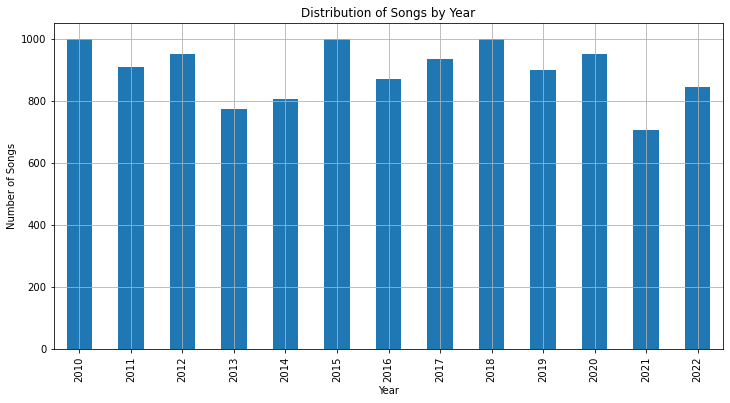

In [39]:
# Count the number of songs per year
yearly_distribution = combined_song_data['Year'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(12, 6))
yearly_distribution.plot(kind='bar')
plt.title('Distribution of Songs by Year')
plt.xlabel('Year')
plt.ylabel('Number of Songs')
plt.grid(True)
plt.show()


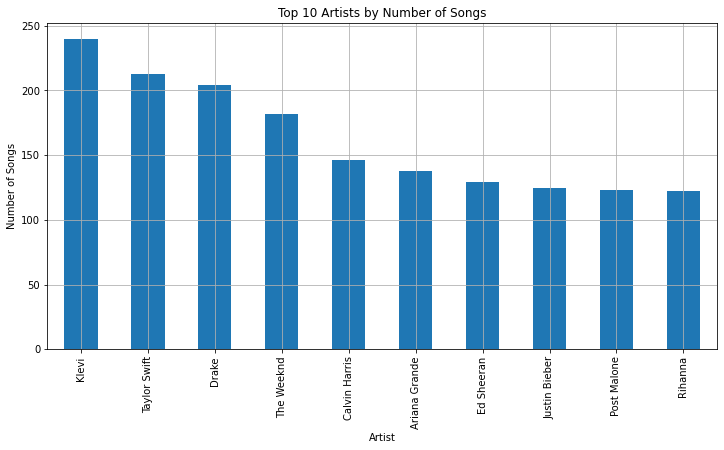

In [35]:
# Count the number of songs per artist and get the top 10
top_artists = combined_song_data['Artist'].value_counts().head(10)

# Plotting
plt.figure(figsize=(12, 6))
top_artists.plot(kind='bar')
plt.title('Top 10 Artists by Number of Songs')
plt.xlabel('Artist')
plt.ylabel('Number of Songs')
plt.grid(True)
plt.show()

